# Setting Up

## load modules

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
import itertools as itt
import os
import sys

import holoviews as hv
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
from holoviews.operation.datashader import datashade, regrid
from holoviews.util import Dynamic
from IPython.core.display import display

## set path and parameters

In [2]:
# Set up Initial Basic Parameters#
minian_path = "."
dpath = "../data/m15/2022_08_02/12_19_25/miniscope_side/"
minian_ds_path = os.path.join(dpath, "minian")
intpath = "~/var/2s_validation/minian_intermediate"
intpath = os.path.normpath(os.path.expanduser(intpath))
subset = dict(frame=slice(0, None))
subset_mc = None
interactive = True
output_size = 100
n_workers = int(os.getenv("MINIAN_NWORKERS", 4))
param_save_minian = {
    "dpath": minian_ds_path,
    "meta_dict": dict(session=-1, animal=-2),
    "overwrite": True,
}

# Pre-processing Parameters#
param_load_videos = {
    "pattern": "[0-9]+\.avi$",
    "dtype": np.uint8,
    "downsample": dict(frame=1, height=1, width=1),
    "downsample_strategy": "subset",
}
param_denoise = {"method": "median", "ksize": 5}
param_background_removal = {"method": "tophat", "wnd": 15}

# Motion Correction Parameters#
subset_mc = None
param_estimate_motion = {"dim": "frame"}

# Initialization Parameters#
param_seeds_init = {
    "wnd_size": 6000,
    "method": "rolling",
    "stp_size": 3000,
    "max_wnd": 40,
    "diff_thres": 8,
}
param_pnr_refine = {"noise_freq": 0.06, "thres": 2}
param_ks_refine = {"sig": 0.05}
param_seeds_merge = {"thres_dist": 15, "thres_corr": 0.6, "noise_freq": 0.06}
param_initialize = {"thres_corr": 0.8, "wnd": 10, "noise_freq": 0.06}
param_init_merge = {"thres_corr": 0.8}

# CNMF Parameters#
param_get_noise = {"noise_range": (0.06, 0.5)}
param_first_spatial = {
    "dl_wnd": 10,
    "sparse_penal": 0.005,
    "size_thres": (35, None),
}
param_first_temporal = {
    "noise_freq": 0.06,
    "sparse_penal": 2,
    "p": 1,
    "add_lag": 100,
    "jac_thres": 0.2,
}
param_first_merge = {"thres_corr": 0.5}
param_second_spatial = {
    "dl_wnd": 10,
    "sparse_penal": 5e-3,
    "size_thres": (35, None),
}
param_second_temporal = {
    "noise_freq": 0.06,
    "sparse_penal": 1,
    "p": 1,
    "add_lag": 100,
    "jac_thres": 0.4,
}

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MINIAN_INTERMEDIATE"] = intpath

## import minian

In [3]:
%%capture
sys.path.append(minian_path)
from minian.cnmf import (
    compute_AtC,
    compute_trace,
    get_noise_fft,
    smooth_sig,
    unit_merge,
    update_spatial,
    update_temporal,
    update_background,
)
from minian.initialization import (
    gmm_refine,
    initA,
    initC,
    intensity_refine,
    ks_refine,
    pnr_refine,
    seeds_init,
    seeds_merge,
)
from minian.motion_correction import apply_transform, estimate_motion
from minian.preprocessing import denoise, remove_background
from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)
from minian.visualization import (
    CNMFViewer,
    VArrayViewer,
    generate_videos,
    visualize_gmm_fit,
    visualize_motion,
    visualize_preprocess,
    visualize_seeds,
    visualize_spatial_update,
    visualize_temporal_update,
    write_video,
)

## module initialization

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
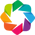

In [4]:
dpath = os.path.abspath(dpath)
hv.notebook_extension("bokeh", width=100)

## start cluster

In [5]:
cluster = LocalCluster(
    n_workers=8,
    memory_limit="4GB",
    resources={"MEM": 1},
    threads_per_worker=2,
    dashboard_address=":12345",
)
annt_plugin = TaskAnnotation()
cluster.scheduler.add_plugin(annt_plugin)
client = Client(cluster)

# Pre-processing

## loading videos and visualization

In [6]:
varr = load_videos(dpath, **param_load_videos)
chk, _ = get_optimal_chk(varr, dtype=float)

loading 18 videos in folder /media/share/csstorage/phild/git/miniscope_2s-validation/analysis/cv_pilot0/data/m15/2022_08_02/12_19_25/miniscope_side


In [7]:
%%time
varr = save_minian(
    varr.chunk({"frame": chk["frame"], "height": -1, "width": -1}).rename("varr"),
    intpath,
    overwrite=True,
)

CPU times: user 2.83 s, sys: 996 ms, total: 3.83 s
Wall time: 18.8 s


## visualize raw data and optionally set roi for motion correction

In [ ]:
hv.output(size=output_size)
if interactive:
    vaviewer = VArrayViewer(varr, framerate=5, summary=["mean", "max"])
    display(vaviewer.show())

In [ ]:
if interactive:
    try:
        subset_mc = list(vaviewer.mask.values())[0]
    except IndexError:
        pass

## subset part of video

In [8]:
varr_ref = varr.sel(subset)

## glow removal and visualization

In [ ]:
%%time
varr_min = varr_ref.min("frame").compute()
varr_ref = varr_ref - varr_min

## denoise

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(
        visualize_preprocess(
            varr_ref.isel(frame=0).compute(),
            denoise,
            method=["median"],
            ksize=[3, 5, 7],
        )
    )

The following cell would carry out denoise step.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [9]:
varr_ref = denoise(varr_ref, **param_denoise)

## glow removal

In [10]:
varr_ref = remove_background(varr_ref.astype(float), method='uniform', wnd=50)

## background removal

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(
        visualize_preprocess(
            varr_ref.isel(frame=0).compute(),
            remove_background,
            method=["tophat"],
            wnd=[10, 15, 20],
        )
    )

The following cell would carry out background removal step.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [11]:
varr_ref = remove_background(varr_ref, **param_background_removal)

## save result

In [12]:
%%time
varr_ref = save_minian(varr_ref.rename("varr_ref"), dpath=intpath, overwrite=True)

CPU times: user 23.3 s, sys: 3.45 s, total: 26.7 s
Wall time: 3min 22s


# Motion Correction

## estimate motion

In [13]:
%%time
motion = estimate_motion(varr_ref.sel(subset_mc), **param_estimate_motion)

CPU times: user 3.61 s, sys: 28.3 ms, total: 3.64 s
Wall time: 3.59 s


## save motion

In [14]:
%%time
motion = save_minian(
    motion.rename("motion").chunk({"frame": chk["frame"]}), **param_save_minian
)

CPU times: user 1min 6s, sys: 7.27 s, total: 1min 13s
Wall time: 6min 49s


In [ ]:
motion = xr.open_dataset('../intermediate/processed/red/m15-rec1.nc')['motion'].compute()
motion.data[:, 0] = -motion.data[:, 0]

In [ ]:
motion = motion.isel(frame=slice(0, 18017))

## visualization of motion

In [15]:
hv.output(size=output_size)
visualize_motion(motion)

:NdOverlay   [Element]
   :Curve   [frame]   (motion)

## apply transform

In [16]:
Y = apply_transform(varr_ref, motion, fill=0)

## save result

In [17]:
%%time
Y_fm_chk = save_minian(Y.astype(float).rename("Y_fm_chk"), intpath, overwrite=True)
Y_hw_chk = save_minian(
    Y_fm_chk.rename("Y_hw_chk"),
    intpath,
    overwrite=True,
    chunks={"frame": -1, "height": chk["height"], "width": chk["width"]},
)

CPU times: user 39.8 s, sys: 8.82 s, total: 48.6 s
Wall time: 4min 9s


## visualization of motion-correction

In [18]:
im_opts = dict(
    frame_width=500,
    aspect=varr_ref.sizes["width"] / varr_ref.sizes["height"],
    cmap="Viridis",
    colorbar=True,
)
(
    regrid(
        hv.Image(
            varr_ref.max("frame").compute().astype(np.float32),
            ["width", "height"],
            label="before_mc",
        ).opts(**im_opts)
    )
    + regrid(
        hv.Image(
            Y_hw_chk.max("frame").compute().astype(np.float32),
            ["width", "height"],
            label="after_mc",
        ).opts(**im_opts)
    )
)

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


:Layout
   .DynamicMap.I  :DynamicMap   []
      :Image   [width,height]   (varr_ref)
   .DynamicMap.II :DynamicMap   []
      :Image   [width,height]   (Y_hw_chk)

## generate video for motion-correction

In [ ]:
%%time
vid_arr = xr.concat([varr_ref, Y_fm_chk], "width").chunk({"width": -1})
write_video(vid_arr, "minian_mc.mp4", dpath)

# Initialization

## compute max projection

In [ ]:
max_proj = save_minian(
    Y_fm_chk.max("frame").rename("max_proj"), **param_save_minian
).compute()

## generating over-complete set of seeds

In [ ]:
%%time
seeds = seeds_init(Y_fm_chk, **param_seeds_init)

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds)

## peak-noise-ratio refine

The following cell would carry out pnr refinement step.
Be sure to [change](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) the `noise_freq` based on visualization results before running the following cell.

In [ ]:
%%time
seeds, pnr, gmm = pnr_refine(Y_hw_chk, seeds, **param_pnr_refine)

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds, "mask_pnr")

## merge seeds

In [ ]:
%%time
seeds_final = seeds[seeds["mask_pnr"]].reset_index(drop=True)
seeds_final = seeds_merge(Y_hw_chk, max_proj, seeds_final, **param_seeds_merge)

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds_final, "mask_mrg")

## initialize spatial matrix

In [ ]:
%%time
A_init = initA(Y_hw_chk, seeds_final[seeds_final["mask_mrg"]], **param_initialize)
A_init = save_minian(A_init.rename("A_init"), intpath, overwrite=True)

## initialize temporal matrix

In [ ]:
%%time
C_init = initC(Y_fm_chk, A_init)
C_init = save_minian(
    C_init.rename("C_init"), intpath, overwrite=True, chunks={"unit_id": 1, "frame": -1}
)

## merge units

In [ ]:
%%time
A, C = unit_merge(A_init, C_init, **param_init_merge)
A = save_minian(A.rename("A"), intpath, overwrite=True)
C = save_minian(C.rename("C"), intpath, overwrite=True)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)

## initialize background terms

In [ ]:
%%time
b, f = update_background(Y_fm_chk, A, C_chk)
f = save_minian(f.rename("f"), intpath, overwrite=True)
b = save_minian(b.rename("b"), intpath, overwrite=True)

## visualization of initialization

In [ ]:
hv.output(size=int(output_size * 0.55))
im_opts = dict(
    frame_width=500,
    aspect=A.sizes["width"] / A.sizes["height"],
    cmap="Viridis",
    colorbar=True,
)
cr_opts = dict(frame_width=750, aspect=1.5 * A.sizes["width"] / A.sizes["height"])
(
    regrid(
        hv.Image(
            A.max("unit_id").rename("A").compute().astype(np.float32),
            kdims=["width", "height"],
        ).opts(**im_opts)
    ).relabel("Initial Spatial Footprints")
    + regrid(
        hv.Image(
            C.rename("C").compute().astype(np.float32), kdims=["frame", "unit_id"]
        ).opts(cmap="viridis", colorbar=True, **cr_opts)
    ).relabel("Initial Temporal Components")
    + regrid(
        hv.Image(
            b.rename("b").compute().astype(np.float32), kdims=["width", "height"]
        ).opts(**im_opts)
    ).relabel("Initial Background Sptial")
    + datashade(hv.Curve(f.rename("f").compute(), kdims=["frame"]), min_alpha=200)
    .opts(**cr_opts)
    .relabel("Initial Background Temporal")
).cols(2)

# CNMF

## estimate spatial noise

In [ ]:
%%time
sn_spatial = get_noise_fft(Y_hw_chk, **param_get_noise)
sn_spatial = save_minian(sn_spatial.rename("sn_spatial"), intpath, overwrite=True)

## first spatial update

### parameter exploration

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    sprs_ls = [0.001, 0.005, 0.01]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_mask, cur_norm = update_spatial(
            Y_hw_chk,
            A_sub,
            C_sub,
            sn_spatial,
            in_memory=True,
            dl_wnd=param_first_spatial["dl_wnd"],
            sparse_penal=cur_sprs,
        )
        if cur_A.sizes["unit_id"]:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = C_sub.sel(unit_id=cur_mask).compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=["sparse penalty"])

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

### spatial update

The following cell would carry out spatial update.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [ ]:
%%time
A_new, mask, norm_fac = update_spatial(
    Y_hw_chk, A, C, sn_spatial, **param_first_spatial
)
C_new = save_minian(
    (C.sel(unit_id=mask) * norm_fac).rename("C_new"), intpath, overwrite=True
)
C_chk_new = save_minian(
    (C_chk.sel(unit_id=mask) * norm_fac).rename("C_chk_new"), intpath, overwrite=True
)

After obtaining a better estimation of spatial footprints, we update the background terms.

In [ ]:
%%time
b_new, f_new = update_background(Y_fm_chk, A_new, C_chk_new)

### visualization of spatial footprints

In [ ]:
hv.output(size=int(output_size * 0.6))
opts = dict(
    plot=dict(height=A.sizes["height"], width=A.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
(
    regrid(
        hv.Image(
            A.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints Initial")
    + regrid(
        hv.Image(
            (A.fillna(0) > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints Initial")
    + regrid(
        hv.Image(
            A_new.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints First Update")
    + regrid(
        hv.Image(
            (A_new > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints First Update")
).cols(2)

### visualization of background

In [ ]:
hv.output(size=int(output_size * 0.55))
opts_im = dict(
    plot=dict(height=b.sizes["height"], width=b.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
opts_cr = dict(plot=dict(height=b.sizes["height"], width=b.sizes["height"] * 2))
(
    regrid(
        hv.Image(b.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial Initial")
    + hv.Curve(f.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal Initial")
    + regrid(
        hv.Image(b_new.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial First Update")
    + hv.Curve(f_new.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal First Update")
).cols(2)

### save results

In [ ]:
%%time
A = save_minian(
    A_new.rename("A"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "height": -1, "width": -1},
)
b = save_minian(b_new.rename("b"), intpath, overwrite=True)
f = save_minian(
    f_new.chunk({"frame": chk["frame"]}).rename("f"), intpath, overwrite=True
)
C = save_minian(C_new.rename("C"), intpath, overwrite=True)
C_chk = save_minian(C_chk_new.rename("C_chk"), intpath, overwrite=True)

## first temporal update

### parameter exploration

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C_chk.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.1, 0.5, 1, 2]
    add_ls = [100]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = (
        compute_trace(Y_fm_chk, A_sub, b, C_sub, f)
        .persist()
        .chunk({"unit_id": 1, "frame": -1})
    )
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(
        p_ls, sprs_ls, add_ls, noise_ls
    ):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print(
            "p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}".format(
                cur_p, cur_sprs, cur_add, cur_noise
            )
        )
        cur_C, cur_S, cur_b0, cur_c0, cur_g, cur_mask = update_temporal(
            A_sub,
            C_sub,
            YrA=YrA,
            sparse_penal=cur_sprs,
            p=cur_p,
            use_smooth=True,
            add_lag=cur_add,
            noise_freq=cur_noise,
        )
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA.compute(),
            cur_C.compute(),
            cur_S.compute(),
            cur_g.compute(),
            (cur_C + cur_b0 + cur_c0).compute(),
            A_sub.compute(),
        )
    hv_res = visualize_temporal_update(
        YA_dict,
        C_dict,
        S_dict,
        g_dict,
        sig_dict,
        A_dict,
        kdims=["p", "sparse penalty", "additional lag", "noise frequency"],
    )

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

### temporal update

In [ ]:
%%time
YrA = save_minian(
    compute_trace(Y_fm_chk, A, b, C_chk, f).rename("YrA"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "frame": -1},
)

The following cell would carry out temporal update.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [ ]:
%%time
C_new, S_new, b0_new, c0_new, g, mask = update_temporal(
    A, C, YrA=YrA, **param_first_temporal
)

### visualization of temporal components

In [ ]:
hv.output(size=int(output_size * 0.6))
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap="Viridis")
(
    regrid(
        hv.Image(
            C.compute().astype(np.float32).rename("ci"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace Initial")
    + hv.Div("")
    + regrid(
        hv.Image(
            C_new.compute().astype(np.float32).rename("c1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace First Update")
    + regrid(
        hv.Image(
            S_new.compute().astype(np.float32).rename("s1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Spikes First Update")
).cols(2)

### visualization of dropped units

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    h, w = A.sizes["height"], A.sizes["width"]
    im_opts = dict(aspect=w / h, frame_width=500, cmap="Viridis")
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = mask.where(mask == False, drop=True).coords["unit_id"].values
    if len(bad_units) > 0:
        hv_res = (
            hv.NdLayout(
                {
                    "Spatial Footprint": Dynamic(
                        hv.Dataset(A.sel(unit_id=bad_units).compute().rename("A"))
                        .to(hv.Image, kdims=["width", "height"])
                        .opts(**im_opts)
                    ),
                    "Spatial Footprints of Accepted Units": Dynamic(
                        hv.Image(
                            A.sel(unit_id=mask).sum("unit_id").compute().rename("A"),
                            kdims=["width", "height"],
                        ).opts(**im_opts)
                    ),
                }
            )
            + datashade(
                hv.Dataset(YrA.sel(unit_id=bad_units).rename("raw")).to(
                    hv.Curve, kdims=["frame"]
                )
            )
            .opts(**cr_opts)
            .relabel("Temporal Trace")
        ).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

### visualization of accepted units

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    sig = C_new + b0_new + c0_new
    display(
        visualize_temporal_update(
            YrA.sel(unit_id=mask),
            C_new,
            S_new,
            g,
            sig,
            A.sel(unit_id=mask),
        )
    )

### save results

In [ ]:
%%time
C = save_minian(
    C_new.rename("C").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
S = save_minian(
    S_new.rename("S").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
b0 = save_minian(
    b0_new.rename("b0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
c0 = save_minian(
    c0_new.rename("c0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
A = A.sel(unit_id=C.coords["unit_id"].values)

## merge units

In [ ]:
%%time
A_mrg, C_mrg, [sig_mrg] = unit_merge(A, C, [C + b0 + c0], **param_first_merge)

In [ ]:
hv.output(size=int(output_size * 0.6))
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap="Viridis")
(
    regrid(
        hv.Image(
            C.compute().astype(np.float32).rename("c1"), kdims=["frame", "unit_id"]
        )
        .relabel("Temporal Signals Before Merge")
        .opts(**opts_im)
    )
    + regrid(
        hv.Image(
            C_mrg.compute().astype(np.float32).rename("c2"), kdims=["frame", "unit_id"]
        )
        .relabel("Temporal Signals After Merge")
        .opts(**opts_im)
    )
)

In [ ]:
%%time
A = save_minian(A_mrg.rename("A_mrg"), intpath, overwrite=True)
C = save_minian(C_mrg.rename("C_mrg"), intpath, overwrite=True)
C_chk = save_minian(
    C.rename("C_mrg_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
sig = save_minian(sig_mrg.rename("sig_mrg"), intpath, overwrite=True)

## second spatial update

### parameter exploration

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = sig.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    sprs_ls = [2e-3, 3e-3, 4e-3]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_mask, cur_norm = update_spatial(
            Y_hw_chk,
            A_sub,
            C_sub,
            sn_spatial,
            in_memory=True,
            dl_wnd=param_second_spatial["dl_wnd"],
            sparse_penal=cur_sprs,
        )
        if cur_A.sizes["unit_id"]:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = C_sub.sel(unit_id=cur_mask).compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=["sparse penalty"])

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

### spatial update

In [ ]:
%%time
A_new, mask, norm_fac = update_spatial(
    Y_hw_chk, A, C, sn_spatial, **param_second_spatial
)
C_new = save_minian(
    (C.sel(unit_id=mask) * norm_fac).rename("C_new"), intpath, overwrite=True
)
C_chk_new = save_minian(
    (C_chk.sel(unit_id=mask) * norm_fac).rename("C_chk_new"), intpath, overwrite=True
)

In [ ]:
%%time
b_new, f_new = update_background(Y_fm_chk, A_new, C_chk_new)

### visualization of spatial footprints

In [ ]:
hv.output(size=int(output_size * 0.6))
opts = dict(
    plot=dict(height=A.sizes["height"], width=A.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
(
    regrid(
        hv.Image(
            A.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints Last")
    + regrid(
        hv.Image(
            (A.fillna(0) > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints Last")
    + regrid(
        hv.Image(
            A_new.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints New")
    + regrid(
        hv.Image(
            (A_new > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints New")
).cols(2)

### visualization of background

In [ ]:
hv.output(size=int(output_size * 0.55))
opts_im = dict(
    plot=dict(height=b.sizes["height"], width=b.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
opts_cr = dict(plot=dict(height=b.sizes["height"], width=b.sizes["height"] * 2))
(
    regrid(
        hv.Image(b.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial Last")
    + hv.Curve(f.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal Last")
    + regrid(
        hv.Image(b_new.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial New")
    + hv.Curve(f_new.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal New")
).cols(2)

### save results

In [ ]:
%%time
A = save_minian(
    A_new.rename("A"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "height": -1, "width": -1},
)
b = save_minian(b_new.rename("b"), intpath, overwrite=True)
f = save_minian(
    f_new.chunk({"frame": chk["frame"]}).rename("f"), intpath, overwrite=True
)
C = save_minian(C_new.rename("C"), intpath, overwrite=True)
C_chk = save_minian(C_chk_new.rename("C_chk"), intpath, overwrite=True)

## second temporal update

### parameter exploration

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C_chk.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.1, 0.5, 1, 2]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = (
        compute_trace(Y_fm_chk, A_sub, b, C_sub, f)
        .persist()
        .chunk({"unit_id": 1, "frame": -1})
    )
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(
        p_ls, sprs_ls, add_ls, noise_ls
    ):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print(
            "p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}".format(
                cur_p, cur_sprs, cur_add, cur_noise
            )
        )
        cur_C, cur_S, cur_b0, cur_c0, cur_g, cur_mask = update_temporal(
            A_sub,
            C_sub,
            YrA=YrA,
            sparse_penal=cur_sprs,
            p=cur_p,
            use_smooth=True,
            add_lag=cur_add,
            noise_freq=cur_noise,
        )
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA.compute(),
            cur_C.compute(),
            cur_S.compute(),
            cur_g.compute(),
            (cur_C + cur_b0 + cur_c0).compute(),
            A_sub.compute(),
        )
    hv_res = visualize_temporal_update(
        YA_dict,
        C_dict,
        S_dict,
        g_dict,
        sig_dict,
        A_dict,
        kdims=["p", "sparse penalty", "additional lag", "noise frequency"],
    )

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

### temporal update

In [ ]:
%%time
YrA = save_minian(
    compute_trace(Y_fm_chk, A, b, C_chk, f).rename("YrA"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "frame": -1},
)

In [ ]:
%%time
C_new, S_new, b0_new, c0_new, g, mask = update_temporal(
    A, C, YrA=YrA, **param_second_temporal
)

### visualization of temporal components

<div class="alert alert-info">

You might notice "Temporal Trace Last" has different number of units than "Spikes Last".
This is because `C` was merged in previous steps while `S` was not.
</div>

In [ ]:
hv.output(size=int(output_size * 0.6))
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap="Viridis")
(
    regrid(
        hv.Image(
            C.compute().astype(np.float32).rename("c1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace Last")
    + regrid(
        hv.Image(
            S.compute().astype(np.float32).rename("s1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Spikes Last")
    + regrid(
        hv.Image(
            C_new.compute().astype(np.float32).rename("c2"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace New")
    + regrid(
        hv.Image(
            S_new.compute().astype(np.float32).rename("s2"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Spikes New")
).cols(2)

### visualization of dropped units

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    h, w = A.sizes["height"], A.sizes["width"]
    im_opts = dict(aspect=w / h, frame_width=500, cmap="Viridis")
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = mask.where(mask == False, drop=True).coords["unit_id"].values
    if len(bad_units) > 0:
        hv_res = (
            hv.NdLayout(
                {
                    "Spatial Footprint": Dynamic(
                        hv.Dataset(A.sel(unit_id=bad_units).compute().rename("A"))
                        .to(hv.Image, kdims=["width", "height"])
                        .opts(**im_opts)
                    ),
                    "Spatial Footprints of Accepted Units": Dynamic(
                        hv.Image(
                            A.sel(unit_id=mask).sum("unit_id").compute().rename("A"),
                            kdims=["width", "height"],
                        ).opts(**im_opts)
                    ),
                }
            )
            + datashade(
                hv.Dataset(YrA.sel(unit_id=bad_units).rename("raw")).to(
                    hv.Curve, kdims=["frame"]
                )
            )
            .opts(**cr_opts)
            .relabel("Temporal Trace")
        ).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

### visualization of accepted units

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    sig = C_new + b0_new + c0_new
    display(
        visualize_temporal_update(
            YrA.sel(unit_id=mask),
            C_new,
            S_new,
            g,
            sig,
            A.sel(unit_id=mask),
        )
    )

### save results

In [ ]:
%%time
C = save_minian(
    C_new.rename("C").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
S = save_minian(
    S_new.rename("S").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
b0 = save_minian(
    b0_new.rename("b0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
c0 = save_minian(
    c0_new.rename("c0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
A = A.sel(unit_id=C.coords["unit_id"].values)

## visualization

In [ ]:
%%time
generate_videos(varr.sel(subset), Y_fm_chk, A=A, C=C_chk, vpath=dpath)

In [ ]:
%%time
if interactive:
    cnmfviewer = CNMFViewer(A=A, C=C, S=S, org=Y_fm_chk)

In [ ]:
hv.output(size=int(output_size * 0.35))
if interactive:
    display(cnmfviewer.show())

## save unit labels

In [ ]:
if interactive:
    A = A.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    C = C.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    S = S.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    c0 = c0.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    b0 = b0.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))

## save final results

In [ ]:
%%time
A = save_minian(A.rename("A"), **param_save_minian)
C = save_minian(C.rename("C"), **param_save_minian)
S = save_minian(S.rename("S"), **param_save_minian)
c0 = save_minian(c0.rename("c0"), **param_save_minian)
b0 = save_minian(b0.rename("b0"), **param_save_minian)
b = save_minian(b.rename("b"), **param_save_minian)
f = save_minian(f.rename("f"), **param_save_minian)

In [ ]:
outds = xr.merge([A, C, S, c0, b0, b, f, max_proj, motion]).assign_coords(animal='m16', session='rec1')

In [ ]:
outds.to_netcdf("../intermediate/processed/green/m15-rec1.nc")

## close cluster

In [ ]:
client.close()
cluster.close()